# < 5. 나의 첫 번째 캐글 경진대회, 무작정 따라해보기 > 

## [루브릭]
- 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?
- 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?
- 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가?

---

## 1. 필요한 라이브러리 import

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import seaborn as sns

### os.path.join()
- 경로와 경로를 합친다
- 운영체제에 맞게 폴더 구분자를 다뤄서 경로를 생성해준다
- 예를 들어 a/b/c라는 경로를 만들고 싶으면 join(a,b,c)로 쓰면 된다

### missingno
- pandas 데이터 프레임 내에서 누락 된 데이터의 존재와 분포를 이해하기 위해 일련의 시각화를 제공하는 훌륭하고 사용하기 쉬운 Python 라이브러리
- 막대 그래프, 행렬 플롯, 히트 맵 또는 덴드로 그램의 형태일 수 있다
    - msno.bar(), msno.matrix(), msno.heatmap(), msno.dendrogram()

### KFold(n_splits=5, shuffle=False, random_state=None)
- 과적합을 막기 위해 사용하는 방법으로 훈련 데이터 세트를 교차하면서 검증을 하는 것을 말한다
- n_splits : 접기 수로 2이상이어야 한다
- shuffle : 배치로 분할하기 전에 데이터를 섞을 지 여부로 각 분할 내의 샘플은 섞이지 않는다
- random_state : 임의성을 제어하는 인덱스의 순서에 영향을 미친다. 

### cross_val_score(estimator, X, y=None, scoring=None, cv=None, n_jobs=1, verbose=0, fit_params=None, pre_dispatch='2*n_jobs' )
- 교차검증을 좀 더 편리하게 수행할 수 있도록 도와주는 함수
- estimatot, X, y, scoring, cv가 중요한 파라미터
    - estimator: 분류 알고리즘 클래스 또는 회귀 알고리즘 클래스를 의미
    - X : 피처 데이터 세트
    - y : 레이블 데이터 세트
    - scoring : 예측 성능 평가 지표('accuracy' , 'neg_brier_score' 등등)
    - cv : 교차 검증 폴드 수

----

## 2. 데이터 가져오기

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')    

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


### 데이터 살펴보기
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

---

## 3. 데이터 전처리

In [3]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [4]:
# date를 int 타입으로 재조정
train['date'] = train['date'].apply(lambda i : i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [5]:
# price 컬럼을 따로 저장하여, train의 타겟 데이터로 분리
y = train['price']
del train['price']

train.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [6]:
# 타켓 데이터
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

In [7]:
# id컬럼 삭제
del train['id']
train.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

> test 데이터에 대해서도 같은 작업 진행.
test 데이터에는 price는 없으니 price에 대한 처리는 해주지 않아도 된다

In [8]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


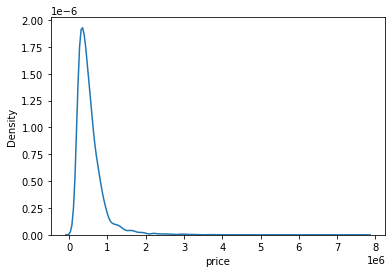

In [9]:
# 가격 데이터 분포 확인
sns.kdeplot(y)
plt.show()

### sns.kdeplot()
- 커널 밀도 추정(KDE: Kernel Density Estimator) : 히스토그램 같은 분포를 부드럽게 곡선화시켜서 그려준다
- sns.kdeplot(data, shade)
    - data : pandas의 DataFrame, 파이썬의 list, numpy의 배열 등 시각화시키고 싶은 데이터 세트
    - shade: 곡선 아래의 공간을 음영 처리할지 결정 (True/False)

> target 데이터를 확인했을 때, 한쪽으로 치우쳐져 있으므로 정규분포 형태로 변환. y는 np.log1p() 함수를 통해 로그 변환을 해주고, 나중에 모델이 값을 예측한 후에 다시 np.expm1()을 활용해서 되돌린다

In [10]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

### np.log1p()
- x = 0 인 경우 log(x)는 -무한대의 값을 갖고 경고 메시지가 뜬다. 이럴 때 사용하는 함수로 'x + 1' 을 해줘서 -inf 값을 0 으로 바꿔준다

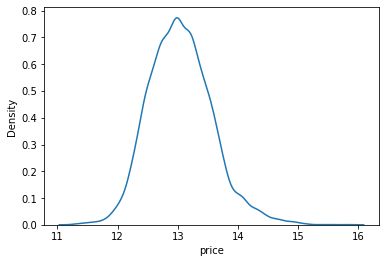

In [11]:
sns.kdeplot(y)
plt.show()

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

---

## 4. 그리드 탐색

In [17]:
from sklearn.model_selection import GridSearchCV

### GridSearchCV
- 클래스 객체에 fit 메서드를 호출하면 grid search를 사용하여 자동으로 복수개의 내부 모형을 생성하고 이를 모두 실행시켜서 최적 파라미터를 찾아준다
- 즉 최적의 파라미터를 찾아주고 교차검증도 해주는 함수!
    - param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
    - scoring : 모델의 성능을 평가할 지표
    - cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
    - verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
    - n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수

In [13]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [14]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

print('submission 함수 세팅')

submission 함수 세팅


### 1. LGBMRegressor
- 트리 기반의 학습 알고리즘인 gradient boosting 방식의 프레임 워크
- 파라미터
    - max_depth : 의사 결정 나무의 깊이, 정수 사용
    - learning_rate : 한 스텝에 이동하는 양을 결정하는 파라미터, 보통 0.0001~0.1 사이의 실수 사용
    - n_estimators : 사용하는 개별 모델의 개수, 보통 50~100 이상의 정수 사용
    - num_leaves : 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수
    - boosting_type : 부스팅 방식, gbdt, rf 등의 문자열 입력

#### (1)

In [28]:
random_state = 2022

param_grid = {
    'learning_rate' : [0.05],
    'n_estimators': [100, 500, 1000],
    'max_depth': [10, 20, 30, 40, 50],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
1,0.05,10,500,-0.025927,0.161020
2,0.05,10,1000,-0.025930,0.161028
5,0.05,20,1000,-0.026044,0.161381
8,0.05,30,1000,-0.026047,0.161392
11,0.05,40,1000,-0.026047,0.161392
14,0.05,50,1000,-0.026047,0.161392
7,0.05,30,500,-0.026054,0.161413
10,0.05,40,500,-0.026054,0.161413
13,0.05,50,500,-0.026054,0.161413
4,0.05,20,500,-0.026067,0.161453


In [30]:
model = LGBMRegressor(max_depth=10, n_estimators=500, learning_rate=0.05, random_state=random_state)

save_submission(model, train, y, test,'lgbm' , rmsle='0.161020')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.161020.csv saved!


![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fda3xQJ%2FbtrrpmD09ds%2FyR5h7YSZIWAcxPTOvGWJh0%2Fimg.png)

> 처음 노드 실습을 통해 그리드 서치로 최적의 조합을 찾았을 때는 120031.23722가 나왔는데 그거보다는 조금 줄어든 점수

#### (2)

In [49]:
param_grid = {
    'learning_rate': [0.01],
    'n_estimators': [500,1000,5000],
    'max_depth': [5, 10, 20, 30, 40, 50],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
17,0.01,50,5000,-0.025784,0.160574
14,0.01,40,5000,-0.025784,0.160574
11,0.01,30,5000,-0.025784,0.160574
8,0.01,20,5000,-0.025800,0.160624
5,0.01,10,5000,-0.025821,0.160688
2,0.01,5,5000,-0.026143,0.161689
4,0.01,10,1000,-0.026687,0.163363
7,0.01,20,1000,-0.026690,0.163371
16,0.01,50,1000,-0.026690,0.163371
10,0.01,30,1000,-0.026690,0.163371


In [50]:
model = LGBMRegressor(max_depth=50, n_estimators=5000, learning_rate=0.01, random_state=random_state)

save_submission(model, train, y, test,'lgbm' , rmsle='0.160574')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.160574.csv saved!
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=100; total time=   0.9s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=500; total time=   1.9s
[CV] END .learning_rate=0.05, max_depth=5, n_estimators=1000; total time=   4.1s
[CV] END .learning_rate=0.05, max_depth=10, n_estimators=100; total time=   0.6s
[CV] END .learning_rate=0.05, max_depth=10, n_estimators=100; total time=   0.6s
[CV] END .learning_rate=0.05, max_depth=10, n_estimators=500; total time=   2.8s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=1000; total time=   4.4s
[CV] END .learning_rate=0.05, max_depth=20, n_estimators=100; total time=   1.3s
[CV] END .learning_rate=0.05, max_depth=20, n_estimators=500; total time=   3.5s
[CV] END learning_rate=0.05, max_depth=20, n_estimators=1000; total time=   5.2s
[CV] END .learning_rate=0.05, max_depth=30, n_estimators=100; total time=   0.6s
[CV] END .learning_rate=0.0

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fbcyso2%2FbtrroXEtu5v%2FX4kYsrFc3xJK4N4SkL9hz1%2Fimg.png)

> max_depth과 n_estimators에 큰 변화를 주었는데 Public Score는 110000 밑으로 떨어졌지만 Private Score는 여전히 110000대에 머물러 있다

#### (3)

In [16]:
random_state = 2022

param_grid = {
    'num_leaves' :[20],
    'learning_rate': [0.01],
    'n_estimators': [5000,50000],
    'max_depth': [5, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
2,0.01,10,5000,20,-0.025684,0.160262
0,0.01,5,5000,20,-0.025981,0.161187
3,0.01,10,50000,20,-0.027175,0.164848
1,0.01,5,50000,20,-0.028056,0.167500


In [17]:
model = LGBMRegressor(max_depth=10, n_estimators=5000, learning_rate=0.01,num_leaves=20, random_state=random_state)

save_submission(model, train, y, test,'lgbm','160262')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_160262.csv saved!
[CV] END learning_rate=0.01, max_depth=5, n_estimators=5000, num_leaves=20; total time=  19.8s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=50000, num_leaves=20; total time= 3.9min
[CV] END learning_rate=0.01, max_depth=10, n_estimators=50000, num_leaves=20; total time= 3.8min
[CV] END learning_rate=0.01, max_depth=5, n_estimators=5000, num_leaves=20; total time=  28.1s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=50000, num_leaves=20; total time= 3.7min
[CV] END learning_rate=0.01, max_depth=10, n_estimators=5000, num_leaves=20; total time=  20.1s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=50000, num_leaves=20; total time= 3.8min
[CV] END learning_rate=0.01, max_depth=5, n_estimators=5000, num_leaves=20; total time=  19.7s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=50000, num_leaves=20; total time= 3.9min
[CV] END learning_rate=0.01, max_depth=10, n_estimators=5

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FrXIIS%2FbtrrunBH4uu%2F13sMlFiSjh4MsyTVOhCBpK%2Fimg.png)

> 이번에는 num_leaves 즉, 한 트리의 leaf 수를 20개로 한정해보았다

#### (4)

In [16]:
model = LGBMRegressor(max_depth=10, n_estimators=20000, learning_rate=0.01,num_leaves=20, random_state=random_state)

save_submission(model, train, y, test,'lgbm')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_None.csv saved!


![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbwAh1W%2FbtrrqZuxXur%2FktzB9HSVHDJEcVdM9kHol1%2Fimg.png)

> n_estimators, 즉 트리의 수를 급격하게 늘려보았다. 그랬더니 private score의 수가 110000 이하로 떨어졌다!!

---

## 5. 다양한 시도

### 2. XGBRegressor
- 약한 분류기를 세트로 묶어서 정확도를 예측하는 기법
- 욕심쟁이(Greedy Algorithm)을 사용하여 분류기를 발견하고 분산처리를 사용하여 빠른 속도로 적합한 비중 파라미터를 찾는 알고리즘
- 병렬 처리를 사용하기에 학습과 분류가 빠르다
- 파라미터:
    - booster : 어떤 부스터 구조를 쓸지 결정 ( gbtree, gblinear, dart )
    - nthread : 몇개의 쓰레드를 동시에 처리하도록 할지 결정. 디폴트는 '가능한 많이'
    - num_feature : feature차원의 숫자를 정해야하는 경우 옵션을 세팅. 자동으로 설정된다
    - eta: learning rate와 같다. 트리에 가지가 많을 수록 과적합하기 쉽다. 매 부스팅 스탭마다 weight를 주어 부스팅 과정에 과적합이 일어나지 않도록 한다.
    - max_depth : 한 트리의 maxium depth. 숫자가를 키울수록 모델의 복잡도가 커진다
    - subsample : 데이터를 일부 발췌해서 다양성을 높이는 방법으로 쓴다. 1 이하의 값을 사용하면 오버 피팅을 방지할 수 있다. 기본값은 1

In [25]:
random_state = 2022

param_grid = {
    'learning_rate': [0.05],
    'subsample': [0.9],
    'n_estimators':[100,500,1000],
    'max_depth': [5, 10],
}

model = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=1)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.9; total time=   4.2s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.9; total time=   4.2s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.9; total time=   4.2s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.9; total time=   4.1s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.9; total time=   4.2s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=500, subsample=0.9; total time=  20.9s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=500, subsample=0.9; total time=  20.9s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=500, subsample=0.9; total time=  20.9s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=500, subsample=0.9; total time=  20.9s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=500, subsample=0.9; total time=  21.0s


,learning_rate,max_depth,n_estimators,subsample,score,RMSLE
2,0.05,5,1000,0.9,-0.025952,0.161097
1,0.05,5,500,0.9,-0.026333,0.162273
4,0.05,10,500,0.9,-0.028459,0.168698
5,0.05,10,1000,0.9,-0.028475,0.168746
3,0.05,10,100,0.9,-0.029089,0.170556
0,0.05,5,100,0.9,-0.031134,0.176447


### 3. GradientBoostingRegressor
- loss : 최적화할 손실함수를 선택(default='ls' (최소 절대 편차))
- learning_rate: 각 트리의 기여도를 나타낸다. (default=0.1)
- n_estimators: 부스팅 단계의 수를 나타낸다. (default=100)
- subsample: 샘플비율을 나타낸다. 1보다 작으면 확률적 그라데이션 부스팅이 발생한다. (default=1.0)
- criterion: 분할하는데의 기준을 선택하는 것이다. 'friedman_mse', 'mse', 'mae'가 존재하며 일반적으로 defalut값인 friedman_mse가 기능이 좋다

In [18]:
random_state = 2022

param_grid = {
    'learning_rate': [0.05],
    'subsample': [0.9],
    'n_estimators':[100,500,1000],
    'max_depth': [1, 5, 10, 20, 30, 40, 50],
}

model = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV] END learning_rate=0.05, max_depth=1, n_estimators=100, subsample=0.9; total time=   1.7s
[CV] END learning_rate=0.05, max_depth=1, n_estimators=500, subsample=0.9; total time=  11.8s
[CV] END learning_rate=0.05, max_depth=1, n_estimators=1000, subsample=0.9; total time=  21.9s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.9; total time=   9.1s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=500, subsample=0.9; total time=  45.1s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=1000, subsample=0.9; total time= 1.6min
[CV] END learning_rate=0.05, max_depth=10, n_estimators=100, subsample=0.9; total time=  14.8s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=500, subsample=0.9; total time= 1.5min
[CV] END learning_rate=0.05, max_depth=10, n_estimators=1000, subsample=0.9; total time= 3.1min
[CV] END learning_rate=0.05, max_depth=20, n_estimators=100, subsample=0.9; total time

,learning_rate,max_depth,n_estimators,subsample,score,RMSLE
5,0.05,5,1000,0.9,-0.025952,0.161097
4,0.05,5,500,0.9,-0.026333,0.162273
7,0.05,10,500,0.9,-0.028459,0.168698
8,0.05,10,1000,0.9,-0.028475,0.168746
6,0.05,10,100,0.9,-0.029089,0.170556
3,0.05,5,100,0.9,-0.031134,0.176447
11,0.05,20,1000,0.9,-0.033947,0.184248
10,0.05,20,500,0.9,-0.033947,0.184248
9,0.05,20,100,0.9,-0.033989,0.184360
17,0.05,40,1000,0.9,-0.034054,0.184536


[CV] END learning_rate=0.05, max_depth=30, n_estimators=100, subsample=0.9; total time=  30.2s
[CV] END learning_rate=0.05, max_depth=30, n_estimators=100, subsample=0.9; total time=  39.7s
[CV] END learning_rate=0.05, max_depth=30, n_estimators=500, subsample=0.9; total time= 2.5min
[CV] END learning_rate=0.05, max_depth=30, n_estimators=1000, subsample=0.9; total time= 2.3min
[CV] END learning_rate=0.05, max_depth=40, n_estimators=500, subsample=0.9; total time= 2.6min
[CV] END learning_rate=0.05, max_depth=40, n_estimators=1000, subsample=0.9; total time= 2.6min
[CV] END learning_rate=0.05, max_depth=50, n_estimators=500, subsample=0.9; total time= 2.5min
[CV] END learning_rate=0.05, max_depth=50, n_estimators=1000, subsample=0.9; total time= 2.1min
[CV] END learning_rate=0.05, max_depth=30, n_estimators=500, subsample=0.9; total time= 2.2min
[CV] END learning_rate=0.05, max_depth=30, n_estimators=1000, subsample=0.9; total time= 2.3min
[CV] END learning_rate=0.05, max_depth=40, n_e

In [20]:
model = GradientBoostingRegressor(max_depth=5, n_estimators=1000, learning_rate=0.05 , subsample=0.9, random_state=random_state)

save_submission(model, train, y, test,'gradientBoostingRe', '0.161097')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_gradientBoostingRe_RMSLE_0.161097.csv saved!


![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FWu7G1%2FbtrrEUL5KCb%2FuwLLn49J9CzDHBGXiQXPhK%2Fimg.png)

### 4. RandomForestRegressor
- n_estimators: 랜덤포레스트의 트리의 수를 말한다. (default=100)
- criterion: 트리를 구분하는 기준으로 mse와 mae 중 하나를 골라야 한다. (default='mse')
- max_depth: 트리의 최대 깊이를 나타내는 것으로 None이면 모든 잎이 순수해질 때까지나 min_samples_split 샘플 미만이 포함될때까지 노드가 확장된다. (defalut=None)
- min_samples_split: 내부 노드를 분할하는 데 필요한 최소 샘플 수이다. (default=2)
- min_samples_leaf: 리프 노드에 있어야하는 최소 샘플 수이다. 왼쪽과 오른쪽 분기 각각에 최소한 훈련샘플을 남겨두는 경우에 고려되며, 회귀에서 모델을 평활화하는데 효과가 있을 수 있다.


In [26]:
param_grid = {
    'n_estimators' : [10, 100],
    'max_depth' : [6, 8, 10, 12],
    'min_samples_leaf' : [8, 12, 18],
    'min_samples_split' : [8, 16, 20]
}

model = RandomForestRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END max_depth=6, min_samples_leaf=8, min_samples_split=8, n_estimators=10; total time=   1.4s
[CV] END max_depth=6, min_samples_leaf=8, min_samples_split=8, n_estimators=100; total time=   9.0s
[CV] END max_depth=6, min_samples_leaf=8, min_samples_split=16, n_estimators=100; total time=   7.0s
[CV] END max_depth=6, min_samples_leaf=8, min_samples_split=20, n_estimators=10; total time=   0.9s
[CV] END max_depth=6, min_samples_leaf=8, min_samples_split=20, n_estimators=100; total time=   8.6s
[CV] END max_depth=6, min_samples_leaf=12, min_samples_split=8, n_estimators=10; total time=   0.7s
[CV] END max_depth=6, min_samples_leaf=12, min_samples_split=8, n_estimators=100; total time=   6.6s
[CV] END max_depth=6, min_samples_leaf=12, min_samples_split=16, n_estimators=10; total time=   0.8s
[CV] END max_depth=6, min_samples_leaf=12, min_samples_split=16, n_estimators=10; total time=   1.2s
[CV] END max_depth=6, min_samples_

,max_depth,min_samples_leaf,min_samples_split,n_estimators,score,RMSLE
55,12,8,8,100,-0.034692,0.186257
57,12,8,16,100,-0.034692,0.186257
59,12,8,20,100,-0.034843,0.186663
65,12,12,20,100,-0.035887,0.189437
63,12,12,16,100,-0.035887,0.189437
...,...,...,...,...,...,...
6,6,12,8,10,-0.052359,0.228821
10,6,12,20,10,-0.052359,0.228821
12,6,18,8,10,-0.052639,0.229433
14,6,18,16,10,-0.052639,0.229433


[CV] END max_depth=12, min_samples_leaf=18, min_samples_split=20, n_estimators=100; total time=  10.2s
[CV] END max_depth=6, min_samples_leaf=8, min_samples_split=8, n_estimators=10; total time=   0.7s
[CV] END max_depth=6, min_samples_leaf=8, min_samples_split=8, n_estimators=100; total time=   8.6s
[CV] END max_depth=6, min_samples_leaf=8, min_samples_split=16, n_estimators=100; total time=   6.5s
[CV] END max_depth=6, min_samples_leaf=8, min_samples_split=20, n_estimators=10; total time=   0.7s
[CV] END max_depth=6, min_samples_leaf=8, min_samples_split=20, n_estimators=10; total time=   0.7s
[CV] END max_depth=6, min_samples_leaf=8, min_samples_split=20, n_estimators=10; total time=   0.7s
[CV] END max_depth=6, min_samples_leaf=8, min_samples_split=20, n_estimators=100; total time=   6.6s
[CV] END max_depth=6, min_samples_leaf=12, min_samples_split=8, n_estimators=10; total time=   0.9s
[CV] END max_depth=6, min_samples_leaf=12, min_samples_split=8, n_estimators=10; total time=   1

- RMSLE이 다른것에 비해 높아서 제출하지 않았다

### 5. VotingRegressor

In [30]:
from sklearn.ensemble import VotingRegressor

In [27]:
param_grid = {
    'boosting' : ['goss'],
    'n_estimators': [1400, 1600, 2000],
    'max_depth': [5, 7, 9, 11, 13],
    'learning_rate': [0.015, 0.018, 0.021, 0.024]
}

In [28]:
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=4)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.015, max_depth=5, n_estimators=1400; total time=   6.5s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.015, max_depth=5, n_estimators=1600; total time=   7.2s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.015, max_depth=5, n_estimators=2000; total time=   9.1s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.015, max_depth=7, n_estimators=1400; total time=   8.1s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boost

,boosting,learning_rate,max_depth,n_estimators,score,RMSLE
18,goss,0.018,7,1400,-0.025554,0.159856
19,goss,0.018,7,1600,-0.025585,0.159952
12,goss,0.015,13,1400,-0.025598,0.159993
13,goss,0.015,13,1600,-0.025612,0.160039
21,goss,0.018,9,1400,-0.025621,0.160066
7,goss,0.015,9,1600,-0.025624,0.160076
22,goss,0.018,9,1600,-0.025632,0.160100
8,goss,0.015,9,2000,-0.025634,0.160105
9,goss,0.015,11,1400,-0.025645,0.160140
11,goss,0.015,11,2000,-0.025654,0.160167


[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.021, max_depth=5, n_estimators=2000; total time=   8.9s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.021, max_depth=5, n_estimators=2000; total time=   8.8s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.021, max_depth=7, n_estimators=1400; total time=   8.2s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.021, max_depth=7, n_estimators=1600; total time=   9.2s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.021, max_depth=7, n_estimators=2000;

In [31]:
xgboost = XGBRegressor(learning_rate=0.05, max_depth=10, n_estimators=1000, random_state=random_state)
lgbm0 = LGBMRegressor(boosting='goss', learning_rate=0.018, max_depth=7, n_estimators=1400, random_state=random_state)
lgbm1 = LGBMRegressor(boosting='goss', learning_rate=0.018, max_depth=7, n_estimators=1600, random_state=random_state)
lgbm2 = LGBMRegressor(boosting='goss', learning_rate=0.015, max_depth=13, n_estimators=1400, random_state=random_state)
lgbm3 = LGBMRegressor(boosting='goss', learning_rate=0.015, max_depth=13, n_estimators=1600, random_state=random_state)
voting = VotingRegressor(estimators=[('xgb', xgboost), ('lgbm0', lgbm0), ('lgbm1', lgbm1), ('lgbm2', lgbm2),('lgbm3', lgbm3)])

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# rmse 함수
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

# score 계산 함수
def get_scores(models, train, y):
    
    df = {}
    
    for model in models:
    # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리 - 여기에도 random_state를 고정
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

        # 모델 학습
        model.fit(X_train, y_train)
    
        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)
    
        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
    return df

In [35]:
get_scores([xgboost, lgbm0, lgbm1, lgbm2, lgbm3, voting], train, y)

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss


{'XGBRegressor': 126529.8433801734,
 'LGBMRegressor': 117554.32936120359,
 'VotingRegressor': 118655.97342031648}

In [36]:
save_submission(voting, train, y, test, "voting", 118655)

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
/aiffel/aiffel/kaggle_kakr_housing/data/submission_voting_RMSLE_118655.csv saved!


In [37]:
save_submission(lgbm0, train, y, test, "lgbm", 117554)

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_117554.csv saved!


![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fzej1s%2FbtrrunJGdmd%2FsktNAepa0IA1hfvagll6Fk%2Fimg.png)

> 둘다 Public Score는 110000 밑으로 떨어졌지만 Private Score는 110000대이다

---

## 6. 정리

### 1. Private score 기준 110000 이하의 점수를 얻었는가?


![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbwAh1W%2FbtrrqZuxXur%2FktzB9HSVHDJEcVdM9kHol1%2Fimg.png)

- n_estimators의 수를 급격하게 변화를 줬더니 Private Score가 110000이하로 떨어졌다
- 사실 많은 시도 끝에 한번 넣어볼까 하고 넣은 값인데 나와서 당황스러웠다
- Private Score는 숨겨진 데이터셋에 의한 score라는데 숨겨진 데이터에 대해 잘 맞았나보다 라고 생각하고 있다.
- 목표점수를 달성하기 위해 넣어본 값인데, n_estimators의 값을 그렇게 크게 넣어도 되나 싶고 과적합이 일어난건 아닌가 싶다.
- 그래도 점수가 나와서 좋다!

### 2. 앙상블(Ensemble)
- 여러개의 머신러닝 모델을 이용해 최적의 답을 찾아내는 기법
- 종류
    - 보팅 (Voting): 투표를 통해 결과 도출
    - 배깅 (Bagging): 샘플 중복 생성을 통해 결과 도출
    - 부스팅 (Boosting): 이전 오차를 보완하면서 가중치 부여
    - 스태킹 (Stacking): 여러 모델을 기반으로 예측된 결과를 통해 meta 모델이 다시 한번 예측
- 참고 : https://teddylee777.github.io/scikit-learn/scikit-learn-ensemble

1. lightGBM
    - 부스팅 계열 알고리즘에 각광받는 모델
    - 학습 시간을 상당히 단축시킨 모델
    - 일반적인 균형 트리 분할 방식과 다르게 리프 중심 트리 분할(Leaf Wise) 방식을 이용
    - https://kimdingko-world.tistory.com/184
2. XGBoost
    - Gradient Boosting 알고리즘을 분산환경에서도 실행할 수 있도록 구현해놓은 라이브러리
    - 여러개의 Decision Tree를 조합해서 사용하는 Ensemble 알고리즘
    - 결측치를 내부적으로 처리하는 장점이 있다고 한다
3. GradientBoostingRegressor
    - 랜덤포레스트의 오차를 보완하는 방법
    - 강력한 가지치기, 트리의 깊이가 깊지 않다
    - 트리의 수와 학습률 두 가지가 중요한 인자라고 한다
4. RandomForestRegressor
    - 의사결정 트리를 랜덤하게 나온 것을 투표하여 결정하는 것
    - n_estimator 는 클 수록 좋다! 트리를 많이 만들어 볼수록 좋다
    - 작은 max_features와 큰 n_estimator 는 과대 적합을 줄인다는 장점이 있다

### 3. 아쉬움, 느낀점
- 데이터 전처리에 대해 아쉬움이 크다. 그리드서치하는데 시간을 너무 많이 써서 데이터를 전처리하는데 시간을 투자하지 못한 점이 아쉽다. 피처를 추가하거나 삭제하고 싶었지만 시간과 능력이 부족했다. 지워도 되는 데이터들이 잘 파헤져보면 있었을 것 같고 히트맵을 이용해서 상관관계를 따져보고 싶었지만 못한게 아쉽다. 데이터 전처리가 중요한만큼 pandas등 데이터를 가공하는데 쓰이는 라이브러리들을 자유자재로 쓸 수 있는 능력을 키워야겠다!!
- XGBRegressor를 처음 탐색할 때 2시간을 기다려도 결과가 나오지 않아서 결국 취소했었다. xgboost의 하이퍼파라미터를 최적화 할 때 GridSearch를 사용하면 오래걸린다고 했었는데 정말 너무 오래걸렸다. 그리고 n_jobs = 5 로 하니까 워닝이 너무 많이 떠서 1로 변경하고 실행하니 워닝이 사라졌다
    - n_jobs : 사용할 코어 수를 지정한다. 사용하는 cpu 코어 개수에 비례해서 속도도 빨라진다
- 처음에는 하이퍼파라미터에 뭘 어떻게 넣어야할지 감이 안와서 무작정 막 넣어봤었다. 하이퍼파라미터 찾는게 어렵다는걸 처음 제대로 느껴볼 수 있었던 프로젝트다.. 그치만 많이 시도한 만큼 머신러닝에 대한 이해와 감이 높아진 것 같아서 좋다!!